# Classical Planning Report
# James McGuigan

## Unit Tests

All unit tests pass:

In [1]:
! pypy3 -m unittest

...................................
----------------------------------------------------------------------
Ran 35 tests in 1.319s

OK


## Performance Optimization

All combinations of problems, heuristics and interpreters where executed in parallel and timed

```bash
time parallel -v -k --joblog ./logs/run_search.python3.joblog "python3 ./run_search.py -p {1} -s {2} | cat" ::: `seq 1 4` ::: `seq 1 11` | tee ./logs/run_search.python3.log
time parallel -v -k --joblog ./logs/run_search.pypy3.joblog   "pypy3   ./run_search.py -p {1} -s {2} | cat" ::: `seq 1 4` ::: `seq 1 11` | tee ./logs/run_search.pypy3.log
```

The following logfiles where generated:

In [2]:
! tree ./logs/

./logs/
├── optimized
│   ├── run_search.pypy3.csv
│   ├── run_search.pypy3.joblog
│   └── run_search.pypy3.log
└── unoptimized
    ├── run_search.pypy3.joblog
    ├── run_search.pypy3.log
    ├── run_search.python3.joblog
    └── run_search.python3.log

2 directories, 7 files


The code was then profiled, memoized and performance optimized with a repeat run to
validate performance metrics and test correctness against the unoptimized implementation.

Correctness of output solutions after optimization can be validated by the following empty diffs

In [3]:
! diff -u logs/unoptimized/run_search.*.log | grep '[+-]' | grep -v 'seconds\|python3\|pypy3\|@@' | wc -l
! diff -u logs/*/run_search.pypy3.log       | grep '[+-]' | grep -v 'seconds\|python3\|pypy3\|@@' | wc -l

0
0


Performance timings can be compared, by summing the per-CPU runtimes of individual runs

Using Intel i7-7700HQ @ 2.8Ghz:
- 38.8h/11.3h = 3.4x | replacing python3 with pypy3
- 11.3h/ 6.7h = 1.7x | adding memoization and optimizing heuristics algorithms
- 38.8h/ 6.7h = 5.8x | total runtime speedup achieved

In [4]:
! awk '{ sum += $4; } ENDFILE { printf "%6ds = %4.1fh = %s\n", sum, sum/60/60, FILENAME; sum = 0 }' logs/*/run_search.*.joblog

 24027s =  6.7h = logs/optimized/run_search.pypy3.joblog
 40557s = 11.3h = logs/unoptimized/run_search.pypy3.joblog
139555s = 38.8h = logs/unoptimized/run_search.python3.joblog



## Experiment with the planning algorithms

> The `run_search.py` script allows you to choose any combination of eleven search algorithms (three uninformed and eight with heuristics) on four air cargo problems. The cargo problem instances have different numbers of airplanes, cargo items, and airports that increase the complexity of the domains.
>
> - You should run **all** of the search algorithms on the first two problems and record the following information for each combination:
>     - number of actions in the domain
>     - number of new node expansions
>     - time to complete the plan search
>
> - Use the results from the first two problems to determine whether any of the uninformed search algorithms should be excluded for problems 3 and 4. You must run **at least** one uninformed search, two heuristics with greedy best first search, and two heuristics with A* on problems 3 and 4.

The log files can be converted into a CSV for pandas

In [5]:
! cat ./logs/optimized/run_search.pypy3.log | grep -P 'Solving|#|^\s*\d|Plan' 2> /dev/null | head -n 8

Solving Air Cargo Problem 1 using breadth_first_search...
# Actions   Expansions   Goal Tests   New Nodes
    20          43          56         178    
Plan length: 6  Time elapsed in seconds: 0.03148065500135999
Solving Air Cargo Problem 1 using depth_first_graph_search...
# Actions   Expansions   Goal Tests   New Nodes
    20          21          22          84    
Plan length: 20  Time elapsed in seconds: 0.013074750007945113


In [6]:
! ( \
echo "problem,algorithm,heuristic,actions,expansions,goal_tests,new_nodes,plan_length,time_seconds"; \
cat ./logs/optimized/run_search.pypy3.log | \
    grep -P 'Solving|#|^\s*\d|Plan' | \
    perl -p -e 's/\n//; s/Solving/\n$&/' | \
    perl -p -e 's/.*?(\b\d+(\.\d+)?|h_\w+(\.\.\.)|\.\.\.|\w+_search)/$1,/g; s/,$//; s/\.\.\.+//; s/^\s*$//m;' \
) | sed '/^$/d' | tee ./logs/optimized/run_search.pypy3.csv | head -n 5


problem,algorithm,heuristic,actions,expansions,goal_tests,new_nodes,plan_length,time_seconds
1,breadth_first_search,,20,43,56,178,6,0.03148065500135999
1,depth_first_graph_search,,20,21,22,84,20,0.013074750007945113
1,uniform_cost_search,,20,60,62,240,6,0.03778048200183548
1,greedy_best_first_graph_search,h_unmet_goals,20,7,9,29,6,0.007534256990766153


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/usr/local/anaconda3/envs/aind/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [8]:
results = pd.read_csv('./logs/optimized/run_search.pypy3.csv', ).fillna('')
# results = results.
results['algorithm'] = results['algorithm'].str.replace('(_graph)?_search','').astype('category')
results['heuristic'] = results['heuristic'].astype('category')
results

,problem,algorithm,heuristic,actions,expansions,goal_tests,new_nodes,plan_length,time_seconds
0,1,breadth_first,,20,43,56,178,6,0.031481
1,1,depth_first,,20,21,22,84,20,0.013075
2,1,uniform_cost,,20,60,62,240,6,0.037780
3,1,greedy_best_first,h_unmet_goals,20,7,9,29,6,0.007534
4,1,greedy_best_first,h_pg_levelsum,20,6,8,28,6,0.295795
5,1,greedy_best_first,h_pg_maxlevel,20,6,8,24,6,0.232050
6,1,greedy_best_first,h_pg_setlevel,20,6,8,28,6,0.598129
7,1,astar,h_unmet_goals,20,50,52,206,6,0.043505
8,1,astar,h_pg_levelsum,20,28,30,122,6,0.543401
9,1,astar,h_pg_maxlevel,20,43,45,180,6,0.588812


> Use the results from the first two problems to determine whether any of the uninformed search algorithms should be excluded for problems 3 and 4.

## Correlations

Growth with problem size
- Depth First Search can produce exponentially long path lengths on larger problems
- Astar with h_pg_maxlevel / h_pg_setlevel can take hours to run on larger problems

A correlation matrix shows
- 0.95 problem/actions = all algorithms and heuristics resulted in optimal path length
- 1.00 expansions/goal_tests/new_nodes = near-perfect linear correlation
- 0.05 plan_length/time_seconds - plan_length is uncorrelated with performance

In [9]:
results.corr().round(2).style.background_gradient(cmap='Greens')

,problem,actions,expansions,goal_tests,new_nodes,plan_length,time_seconds
problem,1,0.95,0.47,0.46,0.47,0.2,0.32
actions,0.95,1,0.38,0.38,0.38,0.16,0.25
expansions,0.47,0.38,1,1,1,0.1,0.24
goal_tests,0.46,0.38,1,1,1,0.09,0.22
new_nodes,0.47,0.38,1,1,1,0.09,0.25
plan_length,0.2,0.16,0.1,0.09,0.09,1,0.05
time_seconds,0.32,0.25,0.24,0.22,0.25,0.05,1


## Report Requirements

## Charts
> Use a table or chart to analyze the number of nodes expanded against number of actions in the domain

Straight lines on a log graph show an exponential correlation between actions and expansions

As the number of actions in the domain increases, the time and nodes expanded exponentially increases,
even though the optimal plan length only increases linearly


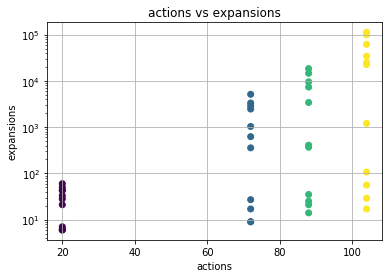

In [10]:
plt.title('actions vs expansions')
plt.scatter(results['actions'], results['expansions'], c=results['problem'])
plt.yscale('log')
plt.xlabel('actions')
plt.ylabel('expansions')
plt.grid()
# plt.show()

> Use a table or chart to analyze the search time against the number of actions in the domain

Log graph fails to render correctly, but we see a similar exponential correlation between actions and time

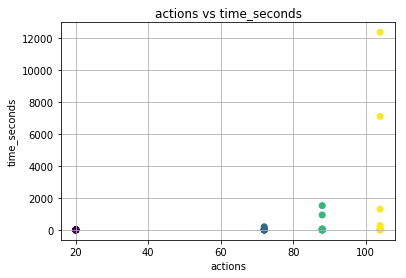

In [11]:
plt.title('actions vs time_seconds')
plt.scatter(results['actions'], results['time_seconds'], c=results['problem'])
plt.xlabel('actions')
plt.ylabel('time_seconds')
plt.grid()
plt.show()

> Use a table or chart to analyze the length of the plans returned by each algorithm on all search problems

Algorithms:
- Path Length
    - Astar + Breadth First + Uniform Cost produce optimal path solutions
    - Depth First Search can produce exponentially long path solutions for large problems
    - Greedy Breadth First Search produces suboptimal but reasonable path lengths

- Expansions
    - Greedy Breadth First Search resulted in the fewest expansions
    - Astar Search performance depends heavily on the heuristic
    - Depth First can result in fewer expansions than Breadth First

- Time
    - Astar with a slow heuristic can be exponentially slower than other algorithms
    - Depth First has very variable timings, can either be very fast or very slow
    - Breadth First + Uniform Cost where the best consinstant performers
    - Greedy Beadth First Search with a fast heuristic is the quickest

Heuristics:
- h_unmet_goals	is the quickest by CPU time, but results in more expansions than h_pg_levelsum
- h_pg_levelsum produces fewest expansions and is reasonably quick
- h_pg_maxlevel	expands similar nodes to h_unmet_goals, but is 100x slower in runtime
- h_pg_setlevel is slightly better than h_unmet_goals but slightly worse than h_pg_levelsum in terms of expansions
- h_pg_setlevel is 2-5x slower than h_pg_maxlevel
- There is a performance tradeoff between the cost of calculating an expensive heuristic and the relative cost of blindly expanding node cheaply


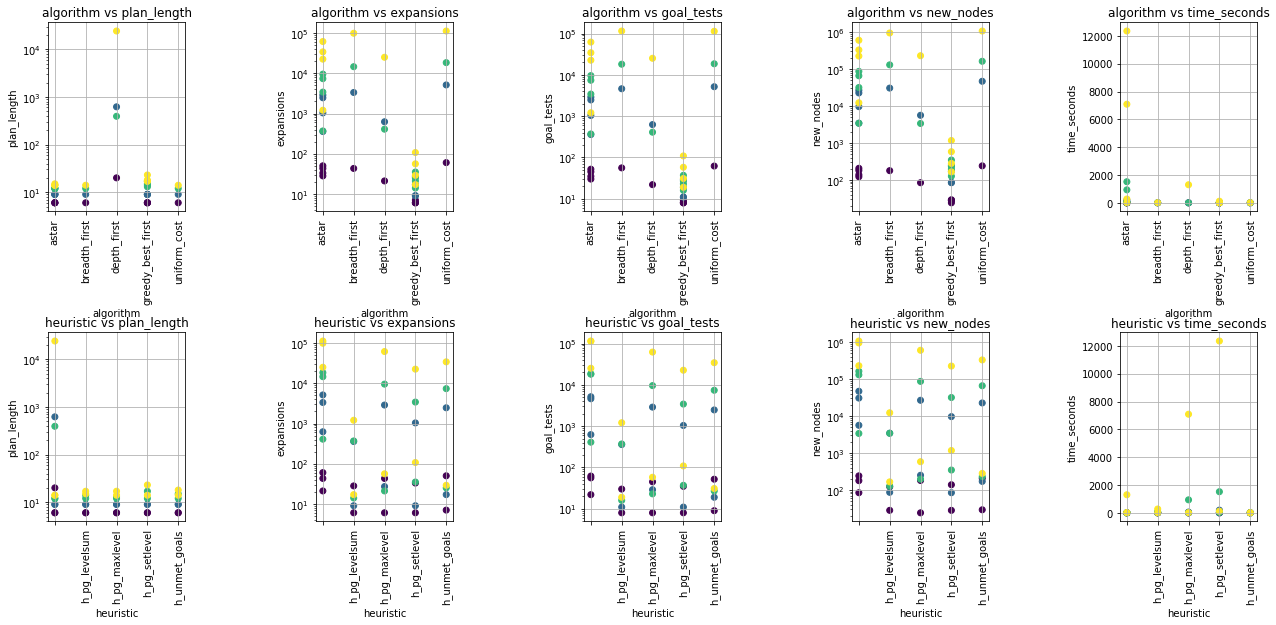

In [12]:
fig, axes = plt.subplots(2,5,figsize=(20,10))
fig.tight_layout(pad=10.0)
index = 0
for alg_or_heur in ['algorithm', 'heuristic']:
    for field in ['plan_length', 'expansions', 'goal_tests', 'new_nodes', 'time_seconds']:
        index += 1
        plt.subplot(2,5,index)

        plt.title(alg_or_heur + ' vs ' + field)
        plt.scatter(results[alg_or_heur], results[field], c=results['problem'])
        plt.xlabel(alg_or_heur)
        plt.ylabel(field)
        if field != 'time_seconds':  # rendering bug
            plt.yscale('log')
        plt.xticks(rotation=90)
        plt.grid()

## Questions

> Which algorithm or algorithms would be most appropriate for planning in a very restricted domain (i.e., one that has only a few actions) and needs to operate in real time?

For Real-Time performance in a small search space
- greedy_breadth_first with h_unmet_goals is the fastest
- greedy_breadth_first can sometimes find optimal paths in small search spaces

Excluded:
- depth_first is 2x slower but produces suboptimal pathing results


In [13]:
results.query('problem == 1').sort_values('time_seconds')

,problem,algorithm,heuristic,actions,expansions,goal_tests,new_nodes,plan_length,time_seconds
3,1,greedy_best_first,h_unmet_goals,20,7,9,29,6,0.007534
1,1,depth_first,,20,21,22,84,20,0.013075
0,1,breadth_first,,20,43,56,178,6,0.031481
2,1,uniform_cost,,20,60,62,240,6,0.037780
7,1,astar,h_unmet_goals,20,50,52,206,6,0.043505
5,1,greedy_best_first,h_pg_maxlevel,20,6,8,24,6,0.232050
4,1,greedy_best_first,h_pg_levelsum,20,6,8,28,6,0.295795
8,1,astar,h_pg_levelsum,20,28,30,122,6,0.543401
9,1,astar,h_pg_maxlevel,20,43,45,180,6,0.588812
6,1,greedy_best_first,h_pg_setlevel,20,6,8,28,6,0.598129


> Which algorithm or algorithms would be most appropriate for planning in very large domains (e.g., planning delivery routes for all UPS drivers in the U.S. on a given day)

For UPS finding an near-optimal route is more cost efficent than saving CPU time
- Breadth first search can still be quick if node expansion is cheap
- Astar/h_unmet_goals also produces fast results, with fewer expansions
- Astar/h_pg_levelsum is technically an inadmissible heuristic, as it finds a near but not perfectly optimal path
- Astar/h_pg_levelsum expands the fewest nodes, which might be worth considering if nodes where more expensive to expand


In [14]:
results.query('problem == 4').sort_values(['plan_length','time_seconds'])

,problem,algorithm,heuristic,actions,expansions,goal_tests,new_nodes,plan_length,time_seconds
40,4,astar,h_unmet_goals,104,34330,34332,328509,14,7.373167
33,4,breadth_first,,104,99736,114953,944130,14,8.662872
35,4,uniform_cost,,104,113339,113341,1066413,14,13.682616
42,4,astar,h_pg_maxlevel,104,62077,62079,599376,14,7088.736812
43,4,astar,h_pg_setlevel,104,22606,22608,224229,14,12350.320764
41,4,astar,h_pg_levelsum,104,1208,1210,12210,15,275.572108
37,4,greedy_best_first,h_pg_levelsum,104,17,19,165,17,6.545626
38,4,greedy_best_first,h_pg_maxlevel,104,56,58,580,17,10.425330
36,4,greedy_best_first,h_unmet_goals,104,29,31,280,18,0.070791
39,4,greedy_best_first,h_pg_setlevel,104,107,109,1164,23,117.109195


> Which algorithm or algorithms would be most appropriate for planning problems where it is important to find only optimal plans?

- Depth First + Greedy Best First as these produce suboptimal paths
- Astar/h_pg_levelsum is technically an inadmissible heuristic, as it finds a near but not perfectly optimal path
- Astar/h_pg_levelsum expands the fewest nodes, which might be worth considering if nodes where more expensive to expand